<a href="https://colab.research.google.com/github/Khai189/TransferLearning/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup our environment

Import neccessary code, requirements, etc.

In [ ]:
import torch
import torchvision

print(torchvision.__version__)

0.24.0+cu126


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Get our data

In [ ]:
import os
import zipfile

from pathlib import Path

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

import requests
def create_data(url):
  """
  Creates data for a computer vision model given a URL that requests can acces
  """
  data_path = Path("data")
  image_path = data_path / "pizza_steak_sushi"

  if image_path.is_dir():
    print(f"{image_path} directory exists, skipping re-download")
  else:
    print(f"Did not find {image_path}, making new path")
    image_path.mkdir(parents=True,
                    exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
      request = requests.get(url)
      f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping our data..")
      zip_ref.extractall(image_path)

    os.remove(data_path / "pizza_steak_sushi.zip")

create_data("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists, skipping re-download


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

## Create our `Datasets` and `DataLoaders`

We can use our `data_setup.py`, specifically the `create_dataloaders.py` function in going_modular


We also need to **transform** the data we get, where there are manual and automatic transforms. We need to be careful if we take another model as we need to transform our data into the same way the model was trained.


We'll manually create transforms for the `torchvision.models`

### Create a transform manually

In [ ]:
from going_modular.going_modular import data_setup

normalize = transforms.Normalize(mean=[.485, .456, .406],
                                 std=[.229,.224,.225])

manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

manual_transform


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               manual_transform,
                                                                               32)

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
img, label = next(iter(train_dataloader))

### Create a transform automatically

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

In [ ]:
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
auto_transforms = weights.transforms

In [ ]:
auto_transforms

functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=224, resize_size=256, interpolation=<InterpolationMode.BICUBIC: 'bicubic'>)

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               auto_transforms(),
                                                                               32)

In [ ]:
len(train_dataloader), len(test_dataloader)

(8, 3)

## Getting a pre-trained model based on the data we want to train on

We can use:
* PyTorch Domain libraries
* HuggingFace Hub
* Libraries like `timm`

Now, we need to choose a model to use. This is done through tons of experimenting on which model best suits our data.

Factors like-
* Speed
* Size
* Computational memory/usage

-can all change what model we choose.

Since we want to run this app on a mobile phone, EffNetB0 is a great option as we don't use too much memory but we need high performance/accuracy.

### Setup our pretained model with an instance:

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

In [ ]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Since we have a small amount of custom data, we want to use **feature extraction** to make our new model

### Getting a summary of our model

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### Freeze base model, change output layer to help suit our dataset

Using feature extraction, we need to freeze our base layers of the pretained model and update the output layers to suit the problem

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Now, we update our classifier

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Train our new model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=.001)

In [ ]:
from going_modular.going_modular import engine
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

# Setup our training
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"Training model took {end_time-start_time} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Training model took 11.502040486999988 seconds.


In [ ]:
results

{'train_loss': [1.0924271196126938,
  0.8716965466737747,
  0.7647950053215027,
  0.7108824998140335,
  0.6254764124751091],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9132681488990784,
  0.791197677453359,
  0.7463406523068746,
  0.6373109221458435,
  0.6261005997657776],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

In [ ]:
import importlib
try:
  from helper_functions import plot_loss_curves
except:
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)

import helper_functions

importlib.reload(helper_functions)

from helper_functions import plot_loss_curves

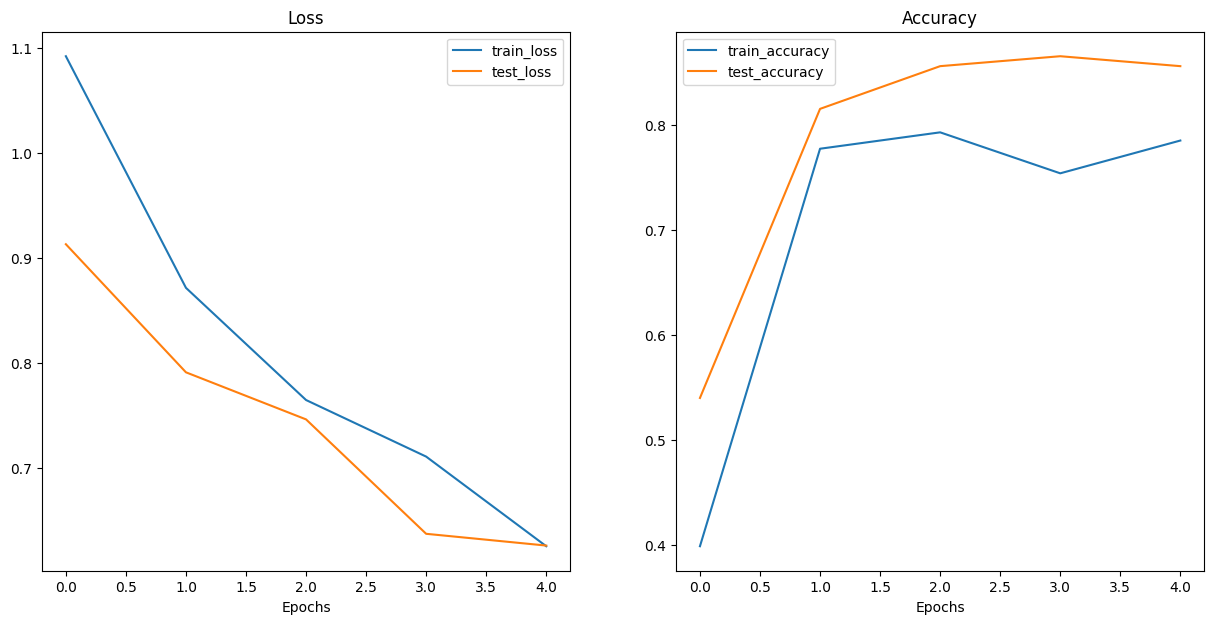

In [ ]:
plot_loss_curves(results)

## Make predictions on test data

We have to format our data correctly, making sure our custom data is the same shape, same datatype, same transform, and same device

In [ ]:
from PIL import Image
from typing import List, Tuple


def pred_and_plot_image(model,
                        image_path,
                        class_names,
                        image_size = (224, 224),
                        transform=None,
                        device = device):

  new_image = Image.open(image_path)

  if transform:
    image_transform = transform
  else:
      image_transform = transforms.Compose([
      transforms.Resize(size=(224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.485, .456, .406],
                                 std=[.229,.224,.225])
  ])

  model = model.to(device)

  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(new_image).unsqueeze(dim=0)

    new_image_probs = model(transformed_image.to(device))
  new_image_preds = torch.softmax(new_image_probs, dim=1).argmax(dim=1)

  plt.figure()
  plt.imshow(new_image)
  plt.title(f"Predicted: {class_names[new_image_preds]} | Prob: {torch.softmax(new_image_probs, dim=1).max():.3f}")



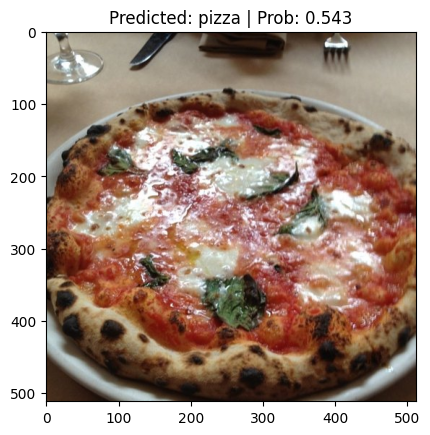

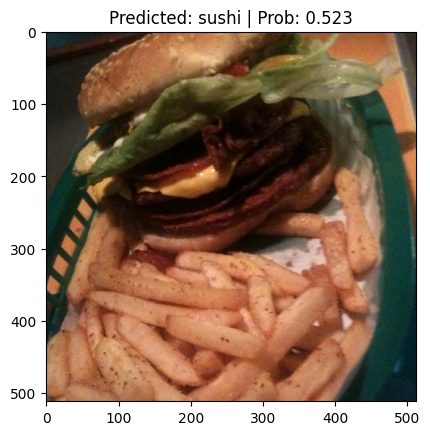

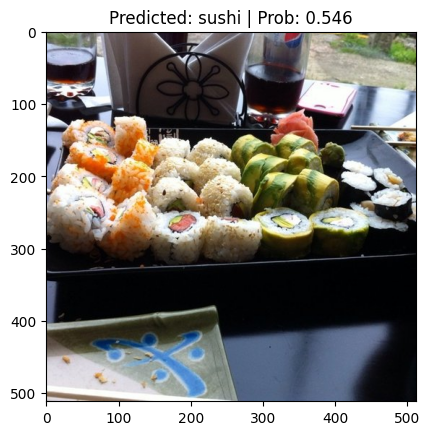

In [ ]:
import random
from pathlib import Path
num_plot_images = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_samples = random.sample(test_image_path_list,
                                   k=num_plot_images)


for image_path in test_image_samples:
  pred_and_plot_image(model,
                      image_path,
                      class_names)

In [ ]:
# Making predictions on the test dataset
try:
  import torchmetrics
  import mlxtend
except:
  !pip install torchmetrics
  !pip install mlxtend

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = MulticlassConfusionMatrix(num_classes=len(class_names)).to(device)

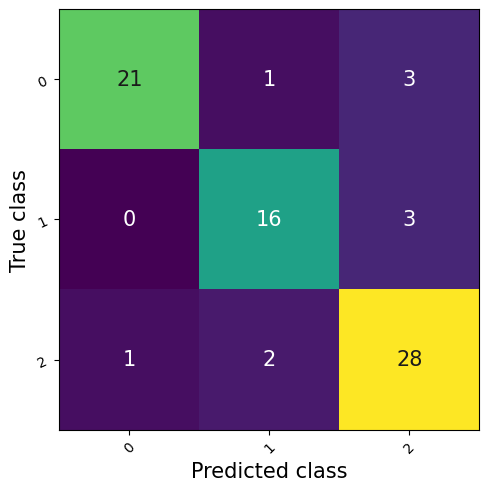

In [ ]:
model.eval()
with torch.inference_mode():
  for batch, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    test_probs = torch.softmax(model(X), dim=1)
    test_preds = torch.argmax(test_probs, dim=1)
    confmat.update(test_preds, y)

  fig, ax = confmat.plot()

In [ ]:
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

def pred_and_store(test_paths, model, transform, class_names):
  test_pred_list = []
  for path in test_paths:
    pred_dict = {}

    class_name = path.parent.stem
    pred_dict["image_path"] = path
    pred_dict["class_name"] = class_name
    from PIL import Image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
      pred_logits = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logits, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label]
      pred_dict["pred_prob"] = pred_prob.max().item()
      pred_dict["pred_label"] = pred_class

      pred_dict["correct"] = class_name == pred_class

      test_pred_list.append(pred_dict)

  return test_pred_list




### Plotting the images the model was the "most" wrong about (had the smallest probability for the correct class)

In [ ]:
test_list = pred_and_store(test_data_paths,
               model,
               manual_transform,
               class_names
)

import pandas as pd
test_pred_df = pd.DataFrame(test_list)
worst_five = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
worst_five

,image_path,class_name,pred_prob,pred_label,correct
3,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.564728,steak,False
56,data/pizza_steak_sushi/test/steak/27415.jpg,steak,0.557891,sushi,False
44,data/pizza_steak_sushi/test/pizza/2871261.jpg,pizza,0.529656,steak,False
41,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.523417,sushi,False
2,data/pizza_steak_sushi/test/sushi/2394442.jpg,sushi,0.421953,pizza,False


In [ ]:
most_wrong_images = worst_five.image_path.tolist()
most_wrong_images

for row in worst_five.iterrows():
  row = row[1]
  true_label = row[1]

[PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg')]

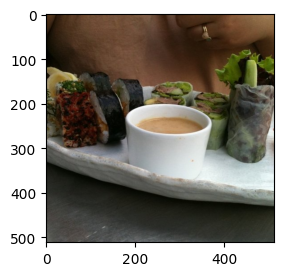

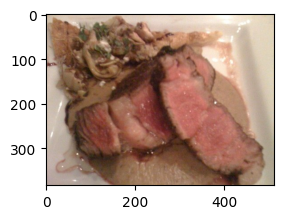

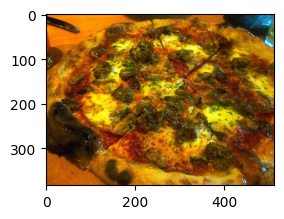

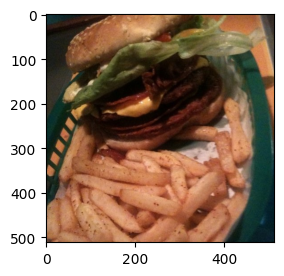

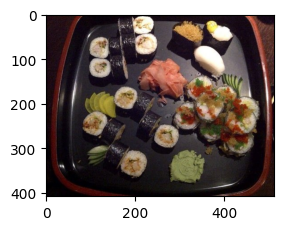

In [ ]:
for i, image_path in enumerate(most_wrong_images):
  img = Image.open(image_path)
  plt.figure(figsize = (10, 7))
  plt.subplot(2, 3, i+1)
  plt.axis(False)
  plt.imshow(img)